## aug

### 86.5 점

In [1]:
import warnings
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D,Dropout, BatchNormalization, Activation
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, TimeDistributed
from keras.engine.topology import get_source_inputs
from keras.utils import layer_utils, to_categorical
from keras import backend as K
from keras import optimizers

Using TensorFlow backend.
/home/pirl/anaconda3/envs/vnect/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/pirl/anaconda3/envs/vnect/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/pirl/anaconda3/envs/vnect/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/pirl/anaconda3/envs/vne

In [19]:
# load dataset list

train_data = pd.read_csv("train_vision_aug_1.csv")
train_filename = train_data["filename"].values.tolist()
train_data["label"] = train_data["label"] -1
train_label = train_data["label"].values.tolist()

test_data = pd.read_csv("test_vision.csv")
test_filename = test_data["filename"].values.tolist()

print(len(train_filename), len(train_label), len(test_filename))

17548 17548 2000


In [20]:
# load train data
input_height , input_width = 128, 128
n_class = 6

def getImageArr(img_name):
        img = cv2.imread("faces_images/" + img_name, 1)
        img = np.float32(img) / 127.5 - 1   #0~255 를 평균 0이게 수정
        return img

X = []
for name in train_filename:
    X.append(getImageArr(name))
    
X, Y = np.array(X), to_categorical(np.array(train_label),n_class)
print(X.shape, Y.shape)

(17548, 128, 128, 3) (17548, 6)


In [21]:
# split dataset

train_rate = 0.85
index_train = np.random.choice(X.shape[0],int(X.shape[0]*train_rate),replace=False)
index_test  = list(set(range(X.shape[0])) - set(index_train))
                            
# X, Y = shuffle(X,Y)
X_train, y_train = X[index_train],Y[index_train]
X_test, y_test = X[index_test],Y[index_test]
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(14915, 128, 128, 3) (14915, 6)
(2633, 128, 128, 3) (2633, 6)


In [22]:
# load test data

real_test = []
for name in test_filename:
    real_test.append(getImageArr(name))
    
real_test = np.array(real_test)
print(real_test.shape)

(2000, 128, 128, 3)


In [23]:
 def nn_base(nClasses, input_height=128, input_width=128):
        
    img_input = Input(shape=(input_height,input_width, 3))
        
    IMAGE_ORDERING =  "channels_last" 
        
    ## Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', data_format=IMAGE_ORDERING )(img_input)
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2', data_format=IMAGE_ORDERING )(x)
    x = BatchNormalization(name='batchnorm1')(x)
    x = Activation('relu', name='activation1')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool', data_format=IMAGE_ORDERING )(x)
    f1 = x
    
    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2', data_format=IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool', data_format=IMAGE_ORDERING )(x)
    f2 = x

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3', data_format=IMAGE_ORDERING )(x)
    x = BatchNormalization(name='batchnorm3')(x)
    x = Activation('relu', name='activation3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool', data_format=IMAGE_ORDERING )(x)    
    pool3 = x

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3', data_format=IMAGE_ORDERING )(x)
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool', data_format=IMAGE_ORDERING )(x) 

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1', data_format=IMAGE_ORDERING )(pool4)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3', data_format=IMAGE_ORDERING )(x)
    pool5 = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool', data_format=IMAGE_ORDERING )(x)
    
    # classification
    x = Flatten(name='flatten')(pool5)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dropout(0.3)(x)
    
    x = Dense(2048, activation='relu', name='fc2')(x)
    x = Dropout(0.3)(x)
    
    x = Dense(1024, activation='relu', name='fc3')(x)
#     x = Dropout(0.3)(x)
    
    x = Dense(512, activation='relu', name='fc4')(x)
#     x = Dropout(0.3)(x)
    
    x = Dense(256, activation='relu', name='fc5')(x)
#     x = Dropout(0.2)(x)
    
    x = Dense(n_class , activation='softmax', name='predictions')(x)
    
    model = Model(img_input, x)

    return model

In [24]:
model = nn_base(nClasses  = n_class,  
             input_height = 128, 
             input_width  = 128)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
batchnorm1 (BatchNormalizati (None, 128, 128, 64)      256       
_________________________________________________________________
activation1 (Activation)     (None, 128, 128, 64)      0         
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
__________

In [25]:
with K.tf.device('/gpu:1'):
    sgd = optimizers.SGD(lr=1E-2, decay=5**(-4), momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])

    hist1 = model.fit(X_train,y_train,
                      validation_data=(X_test,y_test),
                      batch_size=32,epochs=10)

Train on 14915 samples, validate on 2633 samples
Epoch 1/10
14915/14915 [==============================] - 61s 4ms/step - loss: 1.1807 - acc: 0.5654 - val_loss: 0.7864 - val_acc: 0.7239
Epoch 2/10
14915/14915 [==============================] - 60s 4ms/step - loss: 0.4970 - acc: 0.8225 - val_loss: 0.4340 - val_acc: 0.8428
Epoch 3/10
14915/14915 [==============================] - 61s 4ms/step - loss: 0.3196 - acc: 0.8862 - val_loss: 0.3348 - val_acc: 0.8830
Epoch 4/10
14915/14915 [==============================] - 61s 4ms/step - loss: 0.2445 - acc: 0.9104 - val_loss: 0.3188 - val_acc: 0.8921
Epoch 5/10
14915/14915 [==============================] - 61s 4ms/step - loss: 0.1808 - acc: 0.9391 - val_loss: 0.2500 - val_acc: 0.9180
Epoch 6/10
14915/14915 [==============================] - 61s 4ms/step - loss: 0.1355 - acc: 0.9548 - val_loss: 0.2373 - val_acc: 0.9172
Epoch 7/10
14915/14915 [==============================] - 61s 4ms/step - loss: 0.0982 - acc: 0.9687 - val_loss: 0.2157 - val_acc:

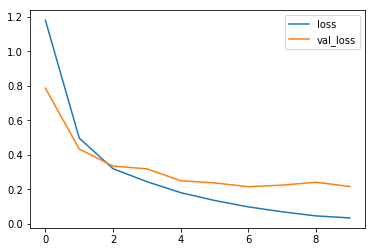

In [26]:
for key in ['loss', 'val_loss']:
    plt.plot(hist1.history[key],label=key)
plt.legend()
plt.show()

In [27]:
y_pred = model.predict(real_test)
y_predi = np.argmax(y_pred,axis = 1) + 1
print(np.unique(y_predi), y_predi.shape)

[1 2 3 4 5 6] (2000,)


In [28]:
answer = pd.DataFrame({"prediction":y_predi})

In [29]:
answer.to_csv('results/6-2.csv',index=False, header="label")